# Classical Response Matrix

In this notebook, I will provide a code to conduct calibration experiments on quantum device.

## I. Introduction of Background Knowledge
The quantum state will lose its coherence and collapse to some particular (classical) state during the measurement...


The calibration experiment is performed by the following steps for a $n-$qubit device,
* Step 1: Prepare a $n-$qubit basis state by adding/removing X gate
* Step 2: Measure the output of prepared basis state
* Step 3: Repeat Step 1 and 2 for all possible $n-$qubit basis states

Namely, one need to perform $2^n$ experiments and get the result for all possible output in each experiment. The calibration experiment can also be illustrated well with the following figure. 

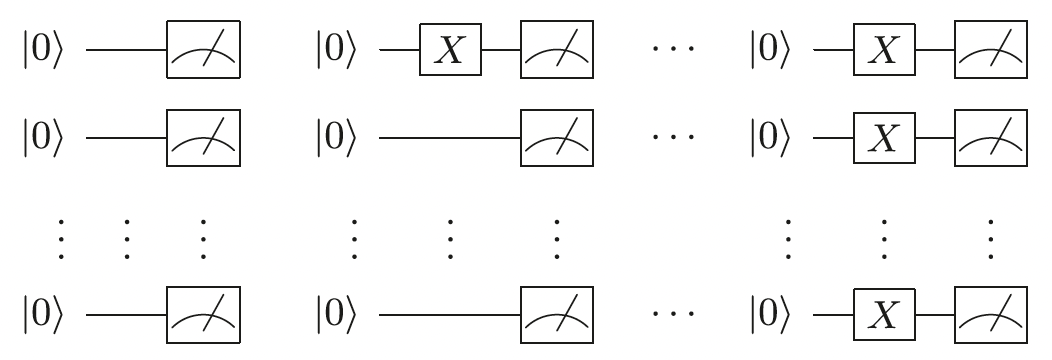

As an example, I will use IBM Q superconducting processor **ibmq_lima** and perform the calibration experiment on it. There are totally $2^5$ circuits need to run on the processor. For the whole process of using qiskit to perform calibration experiment and collect data, we need to

* Know all 5-qubit basis states
* Prepare the circuit for each experiment
* Run the circuit and collect data
* Generate the response matrix

In the following sections, I will provide details of how to run the calibration experiment in a quick way on the device. 

In [1]:
# Import require package
import numpy as np
from qiskit import QuantumCircuit, transpile, IBMQ, assemble
from qiskit.providers.ibmq.job import job_monitor

# Load the IBMQ backend
provider = IBMQ.load_account()
backend = provider.backend.ibmq_lima

## II. Run Calibration Experiment 
In this section, I will describe details of how to finish 4 steps of getting response matrix. 

### A. Get Basis State
I define a recursive function `get_basis_state` to get all $n$-qubit basis states. The output basis state would be a series of binary number in ascending order. For example, the output of $3-$qubit basis is 
\begin{equation}
000, 001, 010, 011, 100, 101, 110, 111
\end{equation}
in ascending order. We can also see the output of `get_basis_state` for $5$ qubits cases below. 

In [2]:
def get_basis_state(nqubit):
    if nqubit <= 0:
        print("nqubit should be greater than 0")
        return 0
    
    if nqubit > 1:
        tmp1 = ['0' + i for i in get_basis_state(nqubit-1)]
        tmp2 = ['1' + i for i in get_basis_state(nqubit-1)]
        return tmp1 + tmp2
    if nqubit == 1:
        return ['0', '1']

In [ ]:
basis_state = get_basis_state(nqubit = 5)
basis_state

### B. Prepare the Circuit
After getting all basis states for the calibration experiment (as shown in the figure), here I create a function `calibrate_experiment` to generate $2^n$ circuits in OpenQASM language. In our example, the `calibrate_experiment` function would produce $2^5$ OpenQASM files, and you can find them in directory `./calibrate/basis_state.txt`.

In [ ]:
def calibrate_experiment(basis_state):
    '''
    Generate OpenQASM file for calibration experiment
    '''
    qasmString = ['OPENQASM 2.0;\n',
                  'include "qelib1.inc";\n', 
                  '\n', 
                  'qreg q[' + str(len(basis_state)) + '];\n', 
                  'creg c[' + str(len(basis_state)) + '];\n', 
                  '\n']
    tmp = basis_state[-1::-1]
    for i in range(len(tmp)):
        if tmp[i] == '0':
            qasmString.append('id q[' + str(i) + '];\n')
        if tmp[i] == '1':
            qasmString.append('x q[' + str(i) + '];\n')
    for i in range(len(tmp)):
        qasmString.append('measure q[' + str(i) + '] -> c[' + str(i) + '];\n')
    
    f = open('./calibrate/' + basis_state + '.txt', 'w')
    f.writelines(qasmString)
    f.close()
    return qasmString

In [ ]:
for state in basis_state:
    calibrate_experiment(state)

### D. Generate Response Matrix
Below I use `run_calibration` function to run all circuits at the same time. Note that the function will automatically read OpenQASM file and load the quantum circuit for each experiment. 

In [ ]:
def run_calibration(basis_state, jobName):
    circList = []
    for i in range(len(basis_state)):
        circList.append(QuantumCircuit.from_qasm_file('./calibrate/' + basis_state[i] + '.txt'))
    
    transpiled = transpile(circList, backend=backend)
    #qobj = assemble(transpiled, backend=backend) # Avoid Warning
    job = backend.run(transpiled, job_name= jobName, shots = 20000)
    #job_monitor(job)
    return job.job_id()

In [ ]:
run_calibration(basis_state, 'lima_calibrate')

### D. Get Response Matrix
After running calibration experiment, we will get a series of output results for different initial state. To construct the response matrix in a proper way, we need to first go into the 

In [11]:
def get_response_matrix(data, nqubit):
    """
    Be careful for the row and column of response matrix. 
    The sum of each column in response matrix is required to be 1, 
    but the sum of each row in response matrix is not required to be 1
    """
    basis_state = get_basis_state(nqubit)
    size = len(basis_state)
    response = np.zeros((size,size)) * np.nan
    for i in range(size): 
        for j in range(size):
            state = basis_state[j]
            try: 
                response[i][j] = data[i][state]
            except KeyError:
                response[i][j] = 0
    
    return response.T

In [4]:
job_id = '61d64935a90e53713073287b'
data = backend.retrieve_job('61d64935a90e53713073287b').result().get_counts()

Note that the sum of each column of response matrix should be equal to 1. Below we do the sum of each column and each row to validate the response matrix construction function. 

In [17]:
matrixA = get_response_matrix(data, 5)/20000
# Sum up all element in each column
np.sum(matrixA, axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [23]:
# Sum up all element in each row
np.sum(matrixA, axis = 1)

array([1.3386 , 1.2563 , 1.258  , 1.18765, 1.11995, 1.04295, 1.0369 ,
       0.96945, 1.266  , 1.18435, 1.18055, 1.10265, 1.049  , 0.97835,
       0.97935, 0.92015, 1.05585, 0.9961 , 0.99165, 0.93365, 0.8919 ,
       0.81935, 0.8223 , 0.76465, 1.0007 , 0.93915, 0.9374 , 0.8723 ,
       0.8301 , 0.7796 , 0.77705, 0.71805])

In [18]:
for i in range(32):
    print(np.sum(matrixA[i]))

1.3386
1.2562999999999998
1.258
1.18765
1.1199500000000002
1.04295
1.0369
0.96945
1.2660000000000002
1.1843499999999998
1.18055
1.1026500000000001
1.049
0.97835
0.97935
0.9201499999999999
1.05585
0.9961000000000001
0.99165
0.93365
0.8919
0.81935
0.8222999999999999
0.7646499999999999
1.0007
0.93915
0.9374
0.8723
0.8301000000000001
0.7796000000000001
0.7770499999999998
0.71805


In [14]:
matrixA.shape

(32, 32)

In [ ]:
import seaborn as sns
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(
    get_response_matrix(data, 5)/20000,
    cmap=sns.color_palette("Blues", as_cmap=True),
    linewidths=.5,
    xticklabels = basis_state,
    yticklabels = basis_state,
    square = True
)